In [1]:
# Imports
import sys
sys.path.append('../python/')
import NGC5533_functions as nf
import numpy as np
import matplotlib.pyplot as plt
import lmfit as lm
import dataPython as dp

In [2]:
data = dp.getXYdata_wXYerr('data/100kpc_data.txt')
r_dat = np.asarray(data['xx'])
v_dat = np.asarray(data['yy'])
v_err0 = np.asarray(data['ex'])
v_err1 = np.asarray(data['ey'])

#for uncertainty band: (from noordermeer's thesis, p.)
delta_i = 3     # guessed value
v_i = (v_dat / np.tan(52*(np.pi/180)) * delta_i *(np.pi/180))

#change r_dat so it's strictly increasing
r_dat, v_dat, v_err0, v_err1 = (np.asarray(list(a)) for a in zip(*sorted(zip(r_dat, v_dat, v_err0, v_err1))))
#converting v_err1 to an array
v_err1_array = np.asarray(v_err1)
# Express as weights
weighdata = 1/(np.sqrt((v_err1**2)+(v_i**2)))

In [3]:
# Define x and y values
#r = np.arange(0.1,200,0.1)
#r = np.linspace(0.1,120,69)
r = r_dat
# Function for fitting only prefactors + halo's parameters + data thief
def f(r,M,rc,rho00,c,pref,gpref):
    return np.sqrt(nf.bh_v(r,M,load=True)**2 
                   + nf.h_v(r,rc,rho00,load=True)**2 
                   + c**2*nf.b_v(r,load=True)**2 
                   + pref**2*nf.d_thief(r)**2
                   + gpref**2*nf.g_thief(r)**2)

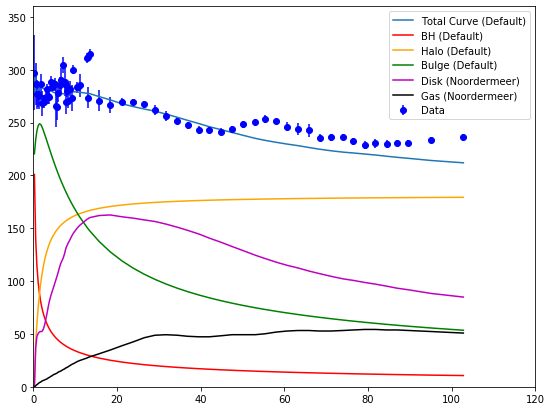

In [4]:
# Plot 
plt.figure(figsize=(9,7))

plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
plt.plot(r,f(r,nf.Mbh_def,nf.h_rc,nf.hrho00_c,1,1,1),label='Total Curve (Default)')
plt.plot(r,nf.bh_v(r,load=True),color='r',label='BH (Default)')
plt.plot(r,nf.h_v(r,load=True),color='orange',label='Halo (Default)')
plt.plot(r,nf.b_v(r,load=True),color='g',label='Bulge (Default)')
plt.plot(r,nf.d_thief(r),color='m',label='Disk (Noordermeer)')
plt.plot(r,nf.g_thief(r),color='k',label='Gas (Noordermeer)')

plt.xlim(0,120)
plt.ylim(0,360)

plt.legend()
plt.show()

In [5]:
# Fit, using prefactors

# Setup
f_mod = lm.Model(f)
f_params = f_mod.make_params()
# Black Hole
f_params.add('M', value=nf.Mbh_def, min=1.0e8)     #Mass
# Halo
f_params.add('rc', value=nf.h_rc, min=0.1)         #Core Radius (kpc)
f_params.add('rho00', value=nf.hrho00_c, min=0)    #Halo Density 
# Bulge
f_params.add('c', value=1,min=0,max=100)           #Prefactor
# Disk
f_params.add('pref', value=1,min=0, max=100)       #Prefactor
# Gas
f_params.add('gpref', value=1,min=.8, max=1.2)     #Prefactor

# Do fit
f_fit = f_mod.fit(v_dat,f_params,r=r_dat,weights=weighdata)

In [6]:
# Define for plotting
bestf = f_fit.best_fit
delf = f_fit.eval_uncertainty()

In [7]:
print('Fit information:')
f_fit

Fit information:


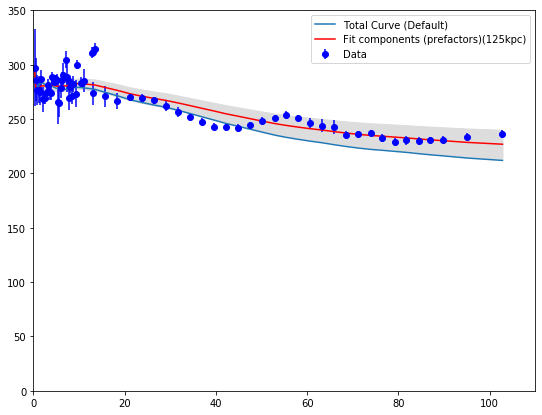

In [8]:
#Plot to 110kpc
plt.figure(figsize=(9,7))

plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
plt.plot(r,f(r,nf.Mbh_def,nf.h_rc,nf.hrho00_c,1,1,1),label='Total Curve (Default)')
plt.plot(r_dat,bestf,'r-',label='Fit components (prefactors)(125kpc)')
plt.fill_between(r_dat,bestf-delf,bestf+delf,color='#dddddd')

plt.xlim(0,110)
plt.ylim(0,350)
plt.legend()
plt.show()

In [9]:
#Define for plotting cont.
f_dict = f_fit.best_values
f_M = f_dict['M']
f_c = f_dict['c']
f_pref = f_dict['pref']
f_rc = f_dict['rc']
f_hrho00 = f_dict['rho00']
f_gpref = f_dict['gpref']

f_curve = f(r,f_M,f_rc,f_hrho00,f_c,f_pref,f_gpref)
bh_curve = nf.bh_v(r,f_M)
halo_curve = nf.h_v(r,f_rc,f_hrho00)
bulge_curve = f_c*nf.b_v(r,load=True)
disk_curve = f_pref*nf.d_thief(r)
gas_curve = f_gpref*nf.g_thief(r)

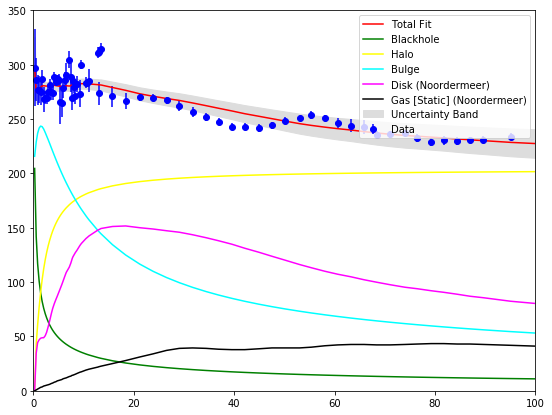

In [10]:
#Plot each fitted component to 100kpc
plt.figure(figsize=(9,7))

plt.plot(r,f_curve,'r-',label='Total Fit')
plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
plt.fill_between(r_dat,bestf-delf,bestf+delf,color='#dddddd',label='Uncertainty Band')
plt.plot(r,bh_curve,'green',label='Blackhole')
plt.plot(r,halo_curve,'yellow',label='Halo')
plt.plot(r,bulge_curve,'cyan',label='Bulge')
plt.plot(r,disk_curve,'magenta',label='Disk (Noordermeer)')
plt.plot(r,gas_curve,'black',label='Gas [Static] (Noordermeer)')

plt.xlim(0,100)
plt.ylim(0,350)
plt.legend()
plt.show()

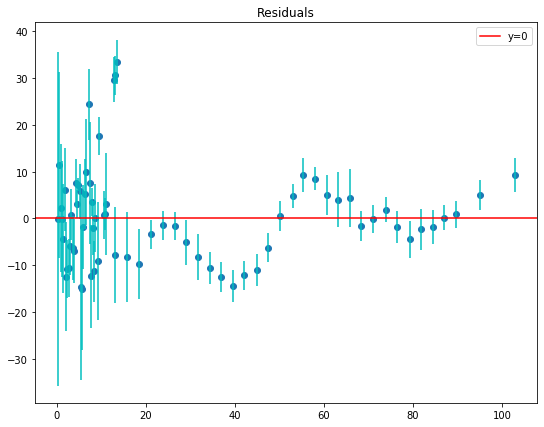

In [11]:
# Residuals
residuals = v_dat - f_curve

# Determining errors
errors = v_err1

# Plot residuals
plt.figure(figsize=(9,7))
plt.title("Residuals")
plt.axhline(y=0, label="y=0", color="r")
plt.scatter(r_dat,residuals)
plt.errorbar(r_dat,residuals,yerr=v_err1, color='c', label='', fmt="none")
plt.legend()
plt.show()

In [12]:
# Chi squared
chisquared = np.sum(residuals**2/errors**2)
# reduced chi squared
reducedchisquared = chisquared * (1/(len(r_dat)-2))
print("The reduced chi squared is {:.10f}.".format(reducedchisquared))

The reduced chi squared is 5.0541259871.


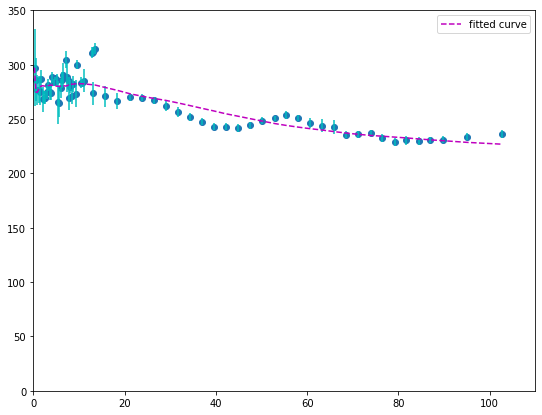

In [13]:
# Plot
plt.figure(figsize=(9,7))
plt.scatter(r_dat,v_dat)
plt.plot(r_dat, f_curve, color="m", linestyle="--", label="fitted curve")
plt.errorbar(r_dat,v_dat,yerr=v_err1, color='c', label='', fmt="none")
plt.xlim(0,110)
plt.ylim(0,350)
plt.legend()
plt.show()

In [14]:
# Chauvenet's Criterion
# List of possible outliers
possible_outliers = []
for v in v_dat:
    if v >= 300:
        possible_outliers.append(v)
possible_outliers = np.array(possible_outliers)
print("Possible outliers: {} km/s.".format(possible_outliers))

# Average and standard deviation of velocities
v_mean = np.mean(v_dat)
v_std = np.std(v_dat)
print("The average velocity is {:.3f} km/s, and the standard deviation is {:.3f} km/s.".format(v_mean,v_std))

# Calculate probability
t = (possible_outliers - v_mean)/v_std
print("The suspected velocities are {} sigma from the mean.".format(t))

# Probability outside tsigma
# Taken from a table of values from Appendix A (Taylor: Introduction to Error Analysis)
probability = 100 - np.array([91.27,86.64,95.45,95.45,96.84])

# Multiply the probabilities with the number of measured points
n = len(v_dat) * probability/100
print("n = {}.".format(n))
print("If n < 1/2, we can reject the outliers. None of these are less than 1/2.")

Possible outliers: [304.6246 300.073  311.12   311.8659 314.6799] km/s.
The average velocity is 266.501 km/s, and the standard deviation is 22.334 km/s.
The suspected velocities are [1.70698095 1.50318175 1.99781437 2.03121225 2.15720992] sigma from the mean.
n = [6.0237 9.2184 3.1395 3.1395 2.1804].
If n < 1/2, we can reject the outliers. None of these are less than 1/2.


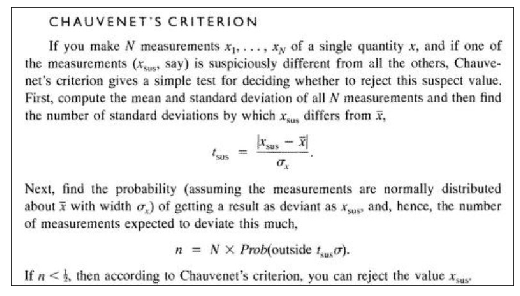

In [15]:
img = plt.imread('../notes/chauvenet.jpg')
plt.figure(figsize=(9,7))
plt.imshow(img) 
plt.xticks([]), plt.yticks([])
plt.show()